In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pandas as pd
from statsmodels.distributions.empirical_distribution import ECDF


In [2]:
def discovery_chance(x, lbda = 1./100.):
    
    return(1-np.exp(-lbda*x))

def failure_chance(x, lbda = 0.004):
    return(np.exp(-lbda*x))



def f(x, Lbdas = [1./100., 0.004]):
    
    return( Lbdas[1]*(Lbdas[0]+Lbdas[1])/Lbdas[0] * discovery_chance(x, Lbdas[0])*failure_chance(x, Lbdas[1]))

def f_example(x, Lbdas = [1./100., 0.004]):
    
    return(  discovery_chance(x, Lbdas[0])*failure_chance(x, Lbdas[1]))



def Error(Params, Data):
    
    DataX, DataY = Data[0], Data[1]
    
    Estimate =  f(DataX, Params)
    
    Diff = (DataY - Estimate)**2
    assert len(Diff)==len(DataX) and len(Estimate) == len(DataX)
    return(np.sum(Diff))
    
    
    

def neg_logL(Params, Data):
    a,b = Params
    
    if a<= 0 or b <= 0:
        return(np.inf)
    else:
        logL = -b*Data + np.log(1-np.exp(-a*Data)) + np.log(b*(a+b)/a)
    
    return(- logL.sum())



def SurvivalFunction(t,Params):
    c,h = Params
    # Moros  c=0.006514 h=67.29 
    # Seshat : c=0.01645 h=161.4
    return(np.exp(-(c*t -c*h*np.log(h+t) + c*h*np.log(h))))

def HazardFunction(t, Params):
    c,h = Params
    return(c*t/(t+h))


def pdf(t, Params): # Their Definition of Hazard Function
    
    return(HazardFunction(t, Params) * SurvivalFunction(t,Params))

def their_neglogl(Params, t):
    
    c, h = Params
    if c<=0 or h<=0:
        return(np.inf)
    else:
        logL = np.log(pdf(t,Params))
        
        return(-logL.sum())

# Now with data

Remember: Hence, we restrict our analysis to states originating in the period between 2000 BCE and 1800 CE.
This period encompasses 324 recorded states in MOROS and 291 polities in Seshat.

### Seshat

In [3]:
DF1 = pd.read_csv("pnas.2218834120.sd01.csv")
print("Full",DF1.shape)

#DF1 = DF1.query("formation >=-2000 and formation<1801 and quasi_polity != True")#[["NaturalGeoArea","age"]].reset_index(drop=True)
DF1 = DF1.query("formation>-2000 and not quasi_polity")
print("Selection",DF1.shape)
print(DF1.head()) 

Seshat_Ages = DF1.age

Full (428, 6)
Selection (291, 6)
   formation  collapse Society_Polity NaturalGeoArea  quasi_polity  age
0       1748      1826        AfDurrn    Kachi Plain         False   78
1       1193      1206        AfGhurd    Kachi Plain         False   13
2       -248      -130        AfGrBct       Sogdiana         False  118
3        426       563        AfHepht       Sogdiana         False  137
4        496       531        AfHepht    Kachi Plain         False   35


In [4]:
set(DF1.quasi_polity) # check

{False}

In [5]:
TheirOpt_Seshat = minimize(their_neglogl,x0 = np.array([0.01, 0.01]).reshape(-1,),
                          bounds = ((0, 1), (0, 1000)), args=(Seshat_Ages), tol =1e-7, 
                          method = "Nelder-Mead")
print(TheirOpt_Seshat)

TheirParam_Seshat = TheirOpt_Seshat.x

 final_simplex: (array([[1.64503697e-02, 1.61370901e+02],
       [1.64503697e-02, 1.61370901e+02],
       [1.64503697e-02, 1.61370901e+02]]), array([1728.00184334, 1728.00184334, 1728.00184334]))
           fun: 1728.0018433370828
       message: 'Optimization terminated successfully.'
          nfev: 211
           nit: 106
        status: 0
       success: True
             x: array([1.64503697e-02, 1.61370901e+02])


In [6]:
print("Compare to reported parameters")

ParamSeshatReported = [0.01645,161.4]

print(their_neglogl(ParamSeshatReported, Seshat_Ages))

Compare to reported parameters
1728.001845577191


In [7]:
MyOpt_Seshat = minimize(neg_logL,x0 = np.array([0.01, 0.01]).reshape(-1,),
                          bounds = ((0, 1), (0, 1)), args=(Seshat_Ages), tol =1e-4, 
                          method = "Nelder-Mead")
print(MyOpt_Seshat)

MyParam_Seshat = MyOpt_Seshat.x

 final_simplex: (array([[8.61375621e-05, 1.18357169e-02],
       [1.48480668e-04, 1.18031210e-02],
       [1.06192067e-04, 1.18213154e-02]]), array([1730.44455013, 1730.44456283, 1730.44456298]))
           fun: 1730.44455012531
       message: 'Optimization terminated successfully.'
          nfev: 65
           nit: 34
        status: 0
       success: True
             x: array([8.61375621e-05, 1.18357169e-02])


In [8]:
print("Delta AIC", 2*(MyOpt_Seshat.fun - TheirOpt_Seshat.fun))

Delta AIC 4.885413576454084


### Moros

In [9]:
DF2 = pd.read_csv("pnas.2218834120.sd02.csv", encoding='unicode_escape')
C = "China"
print("Full",DF2.shape)

#DF2 = DF2.query("formation >=-2000 and formation<1801")#[["Society_Polity", "age"]].reset_index(drop=True)
DF2 = DF2.query("formation<1800 and Region!=@C")
print("Selection",DF2.shape)

Moros_Ages = DF2.age

Full (731, 33)
Selection (324, 33)


In [10]:
TheirOpt_Moros = minimize(their_neglogl,x0 = np.array([0.01, 0.01]).reshape(-1,),
                          bounds = ((0, 1), (0, 1000)), args=(Moros_Ages), tol =1e-7, 
                          method = "Nelder-Mead")
print(TheirOpt_Moros)

TheirParam_Moros = TheirOpt_Moros.x

 final_simplex: (array([[6.75652272e-03, 7.28493367e+01],
       [6.75652272e-03, 7.28493366e+01],
       [6.75652272e-03, 7.28493366e+01]]), array([2081.25536531, 2081.25536531, 2081.25536531]))
           fun: 2081.255365309078
       message: 'Optimization terminated successfully.'
          nfev: 204
           nit: 97
        status: 0
       success: True
             x: array([6.75652272e-03, 7.28493367e+01])


In [11]:
print("Compare to reported parameters")

ParamMorosReported = [0.006514,67.29]

print(their_neglogl(ParamMorosReported, Moros_Ages))

Compare to reported parameters
2081.304795879688


In [12]:
MyOpt_Moros = minimize(neg_logL,x0 = np.array([0.01, 0.01]).reshape(-1,),
                          bounds = ((0, 1), (0, 1000)), args=(Moros_Ages), tol =1e-7, 
                          method = "Nelder-Mead")
print(MyOpt_Moros)

MyParam_Moros = MyOpt_Moros.x

 final_simplex: (array([[0.00657453, 0.0060587 ],
       [0.00657461, 0.00605868],
       [0.00657453, 0.00605869]]), array([2081.80787241, 2081.80787241, 2081.80787241]))
           fun: 2081.80787240672
       message: 'Optimization terminated successfully.'
          nfev: 92
           nit: 48
        status: 0
       success: True
             x: array([0.00657453, 0.0060587 ])


In [13]:
print("Delta AIC", 2*(MyOpt_Moros.fun - TheirOpt_Moros.fun))

Delta AIC 1.1050141952837294


In [14]:
MyParam_Seshat,MyParam_Moros

(array([8.61375621e-05, 1.18357169e-02]), array([0.00657453, 0.0060587 ]))

# Plots

## Seshat

(0.0, 0.01)

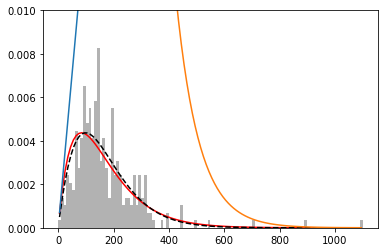

In [15]:
counts1, bin_edges1, _  = plt.hist(DF1.age, bins = np.arange(0, DF1.age.max()+10,10 ), density = True,color="k", alpha = 0.3)
bin_mids1 = bin_edges1[1:]-(bin_edges1[1]-bin_edges1[0])/2
Data1 = [bin_mids1, counts1]
plt.plot(bin_mids1, f(bin_mids1, MyParam_Seshat), c="r")
plt.plot(bin_mids1, pdf(bin_mids1, TheirParam_Seshat), "--",c="k")

Prefactor_Seshat =  MyParam_Seshat.sum()*MyParam_Seshat[1]/MyParam_Seshat[0]

plt.plot(bin_mids1, Prefactor_Seshat * discovery_chance(bin_mids1,MyParam_Seshat[0]))
plt.plot(bin_mids1, Prefactor_Seshat*failure_chance(bin_mids1,MyParam_Seshat[1]))
plt.ylim([0,0.01])

## Moros

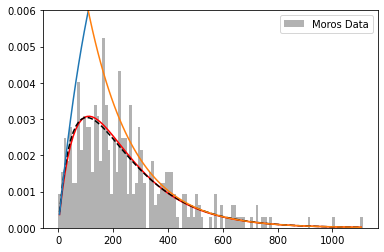

In [16]:
counts2, bin_edges2, _  = plt.hist(DF2.age, bins = np.arange(0, DF2.age.max()+10,10 ), density = True,color="k", alpha = 0.3, label="Moros Data")
bin_mids2 = bin_edges2[1:]-(bin_edges2[1]-bin_edges2[0])/2
Data2 = [bin_mids2, counts2]
plt.plot(bin_mids2, f(bin_mids2, MyParam_Moros), c="r")
plt.plot(bin_mids2, pdf(bin_mids2, TheirParam_Moros), "--",c="k")

Prefactor_Moros = MyParam_Moros.sum()*MyParam_Moros[1]/MyParam_Moros[0]

plt.plot(bin_mids2, Prefactor_Moros * discovery_chance(bin_mids2,MyParam_Moros[0]))
plt.plot(bin_mids2, Prefactor_Moros * failure_chance(bin_mids2,MyParam_Moros[1]))
plt.ylim([0,0.006])
plt.legend()

In [17]:
Prefactor_Seshat, Prefactor_Moros

(1.6381203659010837, 0.011642034096871843)

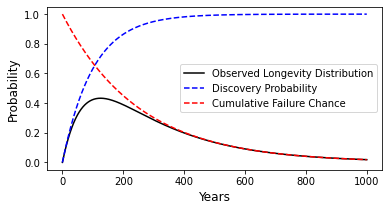

In [18]:
fs = 12
xrange = np.arange(0,1000,1)
fig = plt.figure(figsize = (6,3))

plt.plot(xrange, f_example(xrange), c="k", label="Observed Longevity Distribution")

plt.plot(xrange, discovery_chance(xrange), "--", c="blue", label="Discovery Probability")

plt.plot(xrange, failure_chance(xrange ), "--",c="red", label="Cumulative Failure Chance")#


plt.legend()

plt.xlabel("Years", fontsize = fs)
plt.ylabel("Probability", fontsize = fs)

plt.savefig("SchematicExplanation.pdf", bbox_inches="tight")

## One Figure

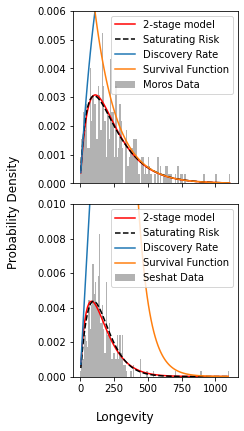

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize = ( 3.42,6))



counts2, bin_edges2, _  = ax1.hist(DF2.age, bins = np.arange(0, DF2.age.max()+10,10 ), density = True,color="k", alpha = 0.3, label="Moros Data")
bin_mids2 = bin_edges2[1:]-(bin_edges2[1]-bin_edges2[0])/2
Data2 = [bin_mids2, counts2]
ax1.plot(bin_mids2, f(bin_mids2, MyParam_Moros), c="r", label="2-stage model")
ax1.plot(bin_mids2, pdf(bin_mids2, TheirParam_Moros), "--",c="k", label="Saturating Risk")

Prefactor_Moros = MyParam_Moros.sum()*MyParam_Moros[1]/MyParam_Moros[0]

ax1.plot(bin_mids2, Prefactor_Moros * discovery_chance(bin_mids2,MyParam_Moros[0]), label="Discovery Rate")
ax1.plot(bin_mids2, Prefactor_Moros * failure_chance(bin_mids2,MyParam_Moros[1]), label="Survival Function")
ax1.set_ylim([0,0.006])
ax1.legend()



counts1, bin_edges1, _  = ax2.hist(DF1.age, bins = np.arange(0, DF1.age.max()+10,10 ), density = True,color="k", 
                                   alpha = 0.3, label="Seshat Data")
bin_mids1 = bin_edges1[1:]-(bin_edges1[1]-bin_edges1[0])/2
Data1 = [bin_mids1, counts1]
ax2.plot(bin_mids1, f(bin_mids1, MyParam_Seshat), c="r", label="2-stage model")
ax2.plot(bin_mids1, pdf(bin_mids1, TheirParam_Seshat), "--",c="k", label="Saturating Risk")

Prefactor_Seshat =  MyParam_Seshat.sum()*MyParam_Seshat[1]/MyParam_Seshat[0]

ax2.plot(bin_mids1, Prefactor_Seshat * discovery_chance(bin_mids1,MyParam_Seshat[0]), label="Discovery Rate")
ax2.plot(bin_mids1, Prefactor_Seshat*failure_chance(bin_mids1,MyParam_Seshat[1]), label="Survival Function")
#ax2.plot(bin_mids2, Prefactor_Moros * discovery_chance(bin_mids2,MyParam_Moros[0]), label="Discovery Rate")
#ax2.plot(bin_mids2, Prefactor_Moros * failure_chance(bin_mids2,MyParam_Moros[1]), label="Survival Function")

ax2.set_ylim([0,0.01])
ax2.legend()

fig.supxlabel("Longevity")
fig.supylabel("Probability Density")

plt.tight_layout()

plt.savefig("Comparison_both_datasets.pdf", dpi = 100)
plt.show()

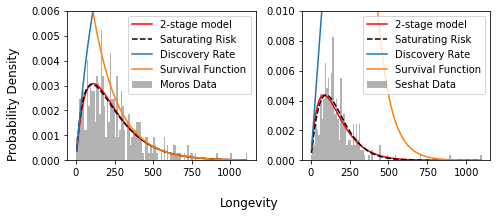

In [20]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = ( 7,3))



counts2, bin_edges2, _  = ax1.hist(DF2.age, bins = np.arange(0, DF2.age.max()+10,10 ), density = True,color="k", alpha = 0.3, label="Moros Data")
bin_mids2 = bin_edges2[1:]-(bin_edges2[1]-bin_edges2[0])/2
Data2 = [bin_mids2, counts2]
ax1.plot(bin_mids2, f(bin_mids2, MyParam_Moros), c="r", label="2-stage model")
ax1.plot(bin_mids2, pdf(bin_mids2, TheirParam_Moros), "--",c="k", label="Saturating Risk")

Prefactor_Moros = MyParam_Moros.sum()*MyParam_Moros[1]/MyParam_Moros[0]

ax1.plot(bin_mids2, Prefactor_Moros * discovery_chance(bin_mids2,MyParam_Moros[0]), label="Discovery Rate")
ax1.plot(bin_mids2, Prefactor_Moros * failure_chance(bin_mids2,MyParam_Moros[1]), label="Survival Function")
ax1.set_ylim([0,0.006])
ax1.legend()



counts1, bin_edges1, _  = ax2.hist(DF1.age, bins = np.arange(0, DF1.age.max()+10,10 ), density = True,color="k", 
                                   alpha = 0.3, label="Seshat Data")
bin_mids1 = bin_edges1[1:]-(bin_edges1[1]-bin_edges1[0])/2
Data1 = [bin_mids1, counts1]
ax2.plot(bin_mids1, f(bin_mids1, MyParam_Seshat), c="r", label="2-stage model")
ax2.plot(bin_mids1, pdf(bin_mids1, TheirParam_Seshat), "--",c="k", label="Saturating Risk")

Prefactor_Seshat =  MyParam_Seshat.sum()*MyParam_Seshat[1]/MyParam_Seshat[0]

ax2.plot(bin_mids1, Prefactor_Seshat * discovery_chance(bin_mids1,MyParam_Seshat[0]), label="Discovery Rate")
ax2.plot(bin_mids1, Prefactor_Seshat*failure_chance(bin_mids1,MyParam_Seshat[1]), label="Survival Function")
#ax2.plot(bin_mids2, Prefactor_Moros * discovery_chance(bin_mids2,MyParam_Moros[0]), label="Discovery Rate")
#ax2.plot(bin_mids2, Prefactor_Moros * failure_chance(bin_mids2,MyParam_Moros[1]), label="Survival Function")

ax2.set_ylim([0,0.01])
ax2.legend()

fig.supxlabel("Longevity")
fig.supylabel("Probability Density")

plt.tight_layout()

plt.savefig("Comparison_both_datasets_row.pdf", dpi = 100)
plt.show()